<a href="https://colab.research.google.com/github/AndyHoskins87/PyTorch_DeepLearning/blob/main/01_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Workflow

Resource Notebook: https://www.learnpytorch.io/01_pytorch_workflow/

Lets explore an example PyTorch end to end workflow.



In [1]:
what_were_covering = {1: "Data (prepare and load)",
2: "Building a model",
3: "Fittinf the model to the training data",
4: "Making predictions and evaluating a model (inference)",
5: "Saving and loading a model",
6: "Putting it all together"}

what_were_covering

{1: 'Data (prepare and load)',
 2: 'Building a model',
 3: 'Fittinf the model to the training data',
 4: 'Making predictions and evaluating a model (inference)',
 5: 'Saving and loading a model',
 6: 'Putting it all together'}

In [57]:
import torch
from torch import nn # nn contains all of pyTorchs building blocks for neural networks
import matplotlib.pyplot as plt

# check pyToch version
torch.__version__

'2.2.1+cu121'

## Data (Preparing and Loading)

Data can be almost anything in machine learning
* Excel Spreadsheets
* Images of any kind
* Video's
* Audio (Songs and Poadcasts)
* text
* DNA

To showcase this, lets create some known data using the linear regression formula.
We'll use a linear regression formula to make a straight line with known parameters.

In [26]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [27]:
len(X), len(y)

(50, 50)

## Spliting data into training and tests sets

* Training Set - The model learns from this data - ~60-80% of the data.
* Validation Set - Model get tuned on this data - ~10-20% of the data.
* Testing Set - The model get evealuated on this data - ~10-20% of the data.

In [5]:
# Create a train/test split
train_split = int(0.8 * len(X)) # 80% of data for training, 20% for testing.

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    '''
    Plots training data, test data and compares predictions.
    '''
    plt.figure(figsize=(10, 7))

    # Plot the training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot the test data in red
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predicitions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="predictions")
    # Show the legend
    plt.legend(prop={"size": 10});

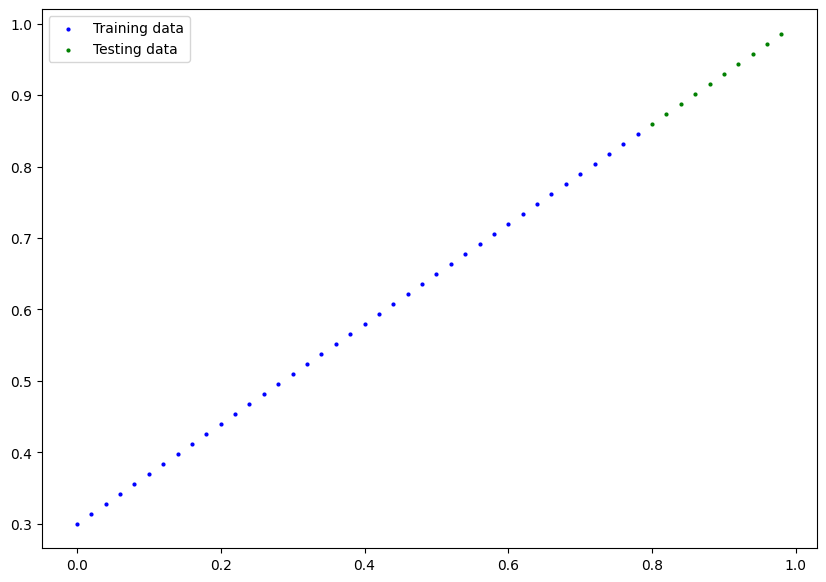

In [7]:
plot_predictions();

## Build a Model

My first PyTorch model!

Because we're are going to be building using python classes, recommend using this resource for OOP: https://realpython.com/python3-object-oriented-programming/

What our model does:
* Starts with random valuse for (weights & bias)
* Looks at the training data and adjusts the random (weights & bias), values to get closer to the ideal values.

How does it do so?
Through two main algorithms:
* Graident Descent - https://youtu.be/IHZwWFHWa-w?si=R7dLnRhJAyqikGRK
* Backpropagation - https://youtu.be/Ilg3gGewQ5U?si=BkRPI8JLAQ-xHXWd

In [30]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # Almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # start with random weights & bias's (this will get adjusted as the model learns)
                                                dtype=torch.float,
                                                requires_grad=True))

        self.bias = nn.Parameter(torch.randn(1,
                                            dtype=torch.float,
                                            requires_grad=True)) # we update this value with gradient descent

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # This is the linear regression formula (y = m*x + b)

PyTorch model building essentials

* `torch.nn` - contains all of the building blocks for computational graphs.
* `torch.nn.parameter` - Stores tensors that can be used with nn.Module (used for updating model parameters via graident descent), are calculated automatically and often referred to as autograd.
* `torch.nn.Module` - The base class for all neural network modules, all the building blocks for neural networks are subclasses.
* `torch.optim` - Contains various different optimization algorithms. (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
* `def forward()` - All nn.Module subclasses require a foward() method, this defines the computation that will take place on the data passed to the particular nn.Module. (Linear regression used above)

Resource: PyTorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html

## Checking the contents of a PyTorch Model

In [31]:
# Set manual seed since nn.Parameters are randomly initialized.
torch.manual_seed(42)

# Create an instance of the model (This is a subclass of nn.Module that contains nn.Parameters)
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [32]:
# List named parameters
model_0.state_dict()
# The closer we get the random values to the W&B we set 0.7/0.3 the better.

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making Predictions using `torch.inference_mode()`

To check our model's predictive power, lets see how well it predicts `y_test` based on `X_test` data.
When we pass data through our model, its going to run through the `forward()` method.

In [33]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions).

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes faster.

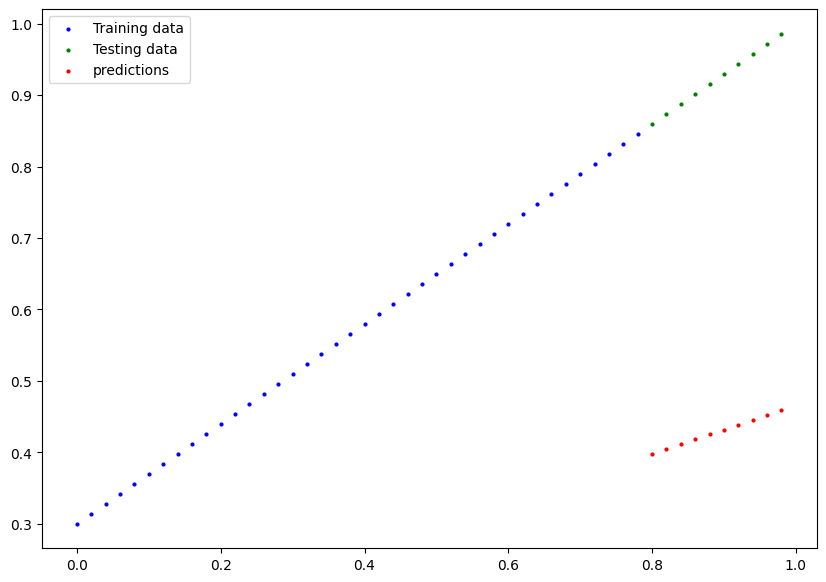

In [34]:
plot_predictions(predictions=y_preds)

## Train Model

The whole idea of training is for a model to move from some unkown parameters (these maybe random), to some known parameters.

* **Loss Function:** A function to measure how wrong your model's predictions are. (Lower is better).

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g weights & bias) to improve the loss function.
    * Inside the Optimizer you'll often have to set two parameters:
        * `params` - the model parameters you'd like t optimize.
        * `lr` - learning rate.

* Training Loop.
* Testing Loop.

In [35]:
# Loss function: L1lose = Mean Absolute Error(MAE) differnce between each element in the input x and target y.
loss_fn = nn.L1Loss()

# Setup an optimizer (SGD) Stochastic Graident Descent
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # Learning Rate hyperparameter


## Building a Training & Testing loop in PyTorch

Training Loop:
0. Loop through the data
1. Forward pass - This involves data moving through our model's `forward()` functions. Also called forward propagation.
2. Calculate the loss (compare forward pass predictions to ground truth labels).
3. Optimizer Zero Grad
4. Loss backward - move backwards through the newtwork to calculate the gradients of each of the parameters of our model with respect to the loss (**Backpropagation**).
5. Optimizer - Use the optimizer to adjust our models parameters to try and improve the loss (**Graident Descent**)

In [62]:
torch.manual_seed(42)
# An epoch is one loop through the data
epochs = 100
# Training
for epoch in range(epochs):
    model_0.train() # Set the model to training mode

    # Forward Pass
    y_pred = model_0(X_train)

    # Calculate the loss
    loss = loss_fn(y_pred, y_train)
    #print(f"Loss: {loss}")

    # Optimizer Zero Grad
    optimizer.zero_grad()  # by default the optimizer changes will accumulate through the loop so... we have to zero them before the next loop.

    # Perform backpropagation
    loss.backward()

    # Step the optimizer (perform graident descent)
    optimizer.step()

    #Testing
    model_0.eval() # Turns off graident tracking.
    #print(model_0.state_dict())

In [36]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [65]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6074])), ('bias', tensor([0.3388]))])

In [63]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

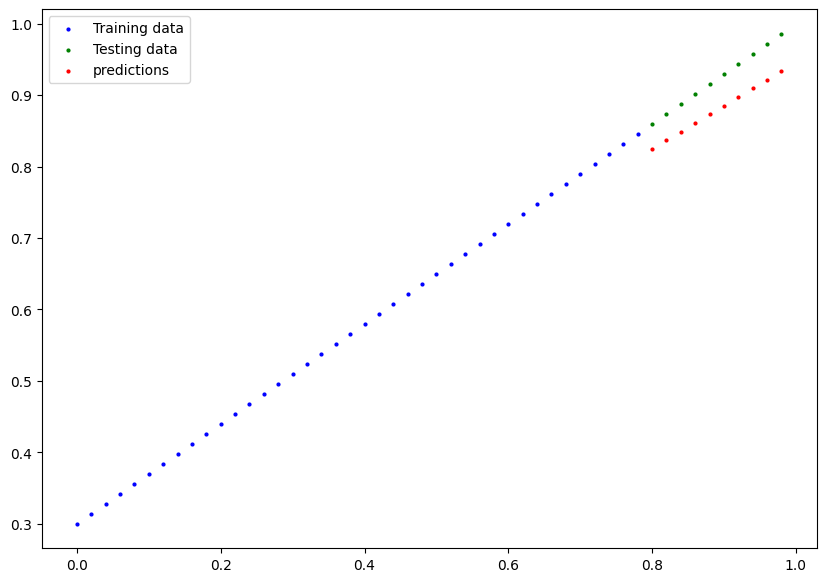

In [64]:
plot_predictions(predictions=y_preds_new)